# Prueba de RNA usando LSTM

Fuentes:
- https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
- https://iamtrask.github.io/2015/11/15/anyone-can-code-lstm/

Según dicen:

_Neural networks like Long Short-Term Memory (LSTM) recurrent neural networks are able to almost seamlessly model problems with multiple input variables._
_This is a great benefit in time series forecasting, where classical linear methods can be difficult to adapt to multivariate or multiple input forecasting problems._

## Carga y preparación del dataset

In [409]:
# En la Rpi se podría achicar importando solo lo comentado.
# from pandas import DataFrame, Series, concat, read_csv, detime, 
import pandas as pd

# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import MinMaxScaler
import sklearn

# from keras.models import Sequential
# from keras.layers import Dense, LSTM
import keras

from math import sqrt
from matplotlib import pyplot as plt

import numpy as np

# Import mysql to extract dataset directly from db
import MySQLdb


In [410]:
%matplotlib inline

### Conexión al DWH

In [411]:
# Base de datos histórica
dbname_hist = "ratio_dwh"
dbhost_hist = "localhost"
dbport_hist = 3306
dbuser_hist = "root"
dbpass_hist = "root"
device_events_tbl = "device_events"
device_event_sensors_tbl = "device_event_sensors"
device_modules_tbl = "device_modules"

### Variables de configuración

In [412]:
device_id = 5                   # Device id donde esta el modulo a entrenar
lux_module_id = 51              # Modulo a entrenar

# Variables de tipos de sensores
ACS_SENSOR_TYPE = 1
LIGHT_SENSOR_TYPE = 2
MOVEMENT_SENSOR_TYPE = 3
SOUND_SENSOR_TYPE = 4
TEMP_SENSOR_TYPE = 5

### Funciones

In [413]:
# Funcion para pasar de sensor_id a nombre
def sensorIdToStr(sensor_id):
    return {
        ACS_SENSOR_TYPE: 'LUX_ACS',
        LIGHT_SENSOR_TYPE: 'LIGHT',
        MOVEMENT_SENSOR_TYPE: 'MOVEMENT',
        SOUND_SENSOR_TYPE: 'SOUND',
        TEMP_SENSOR_TYPE: 'TEMPERATURE'
    }.get(sensor_id, sensor_id)

## Extracción de datos del dwh:

In [414]:
# Estrayendo valores de la tabla de eventos
conn = MySQLdb.connect(host=dbhost_hist, port=dbport_hist, user=dbuser_hist, passwd=dbpass_hist, db=dbname_hist)
from_stm = 'FROM ' + device_events_tbl + ' de LEFT JOIN ' + device_event_sensors_tbl + ' des ON de.id=des.device_event_id '
where_stm = 'WHERE device_id = ' + str(device_id) + ' AND module_id = ' + str(lux_module_id) + ' AND ts BETWEEN DATE_SUB(NOW(), INTERVAL 90 DAY) AND NOW()'
%time df_events_qry = pd.read_sql('select ts, state, sensor_type_id, value ' + from_stm + where_stm, con=conn)
conn.close()

CPU times: user 2.3 s, sys: 69.7 ms, total: 2.37 s
Wall time: 5.19 s


In [415]:
df_events_qry.head(5)

,ts,state,sensor_type_id,value
0,2017-08-14 12:48:00,0,2,558.000000
1,2017-08-14 12:48:00,0,4,35.957244
2,2017-08-14 12:48:00,0,3,0.000000
3,2017-08-14 12:48:00,0,1,0.004855
4,2017-08-14 12:49:00,0,2,544.000000


### Generación de dataset para entrenamiento

In [416]:
# Se elininan los eventos de estado sin sensado
df_events_qry.dropna(inplace=True)

In [417]:
# Se "aplanan" los eventos con una tabla pivot sobre la columna sensor_type_id
df_events = df_events_qry.pivot_table(index=['ts','state'], columns='sensor_type_id', values='value', aggfunc=np.mean)
# Se elimina el multiindex de columnas generado por pivot_table
df_events = df_events.reset_index().rename_axis(None, axis=1)
# Se renombran las columnas
df_events.rename(columns={'ts': 'TIMESTAMP', 'state': 'LUX_ON'},inplace=True)
df_events.columns = [ sensorIdToStr(colname) for colname in df_events.columns ]

In [418]:
df_events.head(5)

,TIMESTAMP,LUX_ON,LUX_ACS,LIGHT,MOVEMENT,SOUND
0,2017-08-14 12:48:00,0,0.004855,558.0,0.0,35.957244
1,2017-08-14 12:49:00,0,0.007448,544.0,0.0,33.216097
2,2017-08-14 12:50:00,0,0.011065,561.0,0.0,38.230083
3,2017-08-14 12:51:00,0,0.007314,624.0,0.0,33.121618
4,2017-08-14 12:52:00,0,0.003594,624.0,0.0,33.913407


## Limpieza del dataset
Debido a que no se necesitan todas las columnas para realizar el entrenamiento de la RNA, se eliminan las que no representen relación con lo que se busca predecir.

- Las medicion LUX_ACS puede ignorarse para este tipo de entrenamiento, ya que es practicamente lineal con LUX_ON.
- Timestamp puede eliminarse, ya que en LSTM se utilizan los valores de registros anteriores para determinar el actual


In [419]:
del df_events['LUX_ACS']
del df_events['TIMESTAMP']

### Ajuste y transformación de variables
Se aplican ajustes y correcciones a las variables del dataset

In [420]:
df_events['MOVEMENT'] = df_events.MOVEMENT.astype(int)

## Análisis Exploratorio inicial


Para conocer en que orden se mueven las variables, voy a hacer un gráfico inicial con una muestra equivalente a aproximadamente una semana, no los tres meses del dataset.

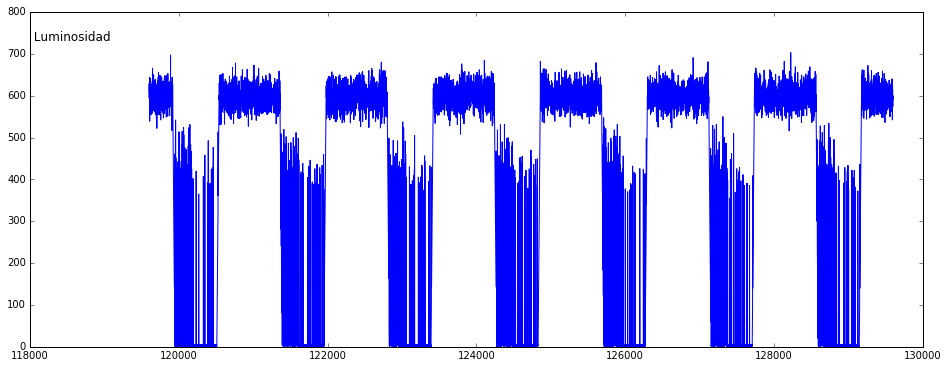

In [421]:
plt.figure(num=None, figsize=(16, 6), facecolor='w', edgecolor='k')
plt.title(' Luminosidad', y=0.9, loc='left')
plt.plot(df_events['LIGHT'].tail(10000))
plt.show()

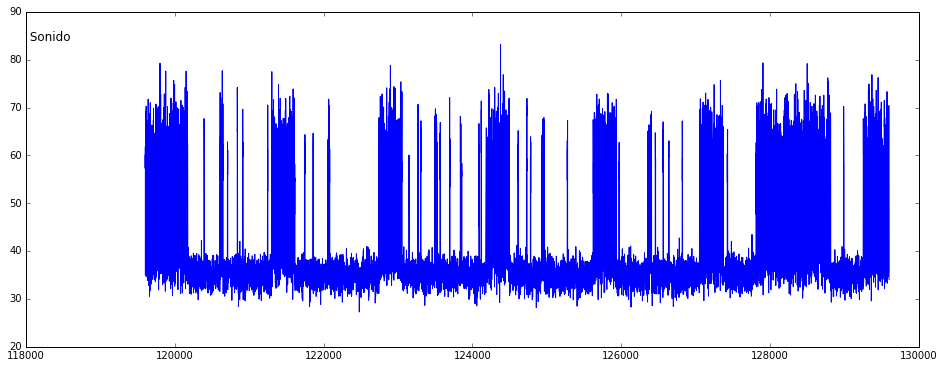

In [422]:
plt.figure(num=None, figsize=(16, 6), facecolor='w', edgecolor='k')
plt.title(' Sonido', y=0.9, loc='left')
plt.plot(df_events['SOUND'].tail(10000))
plt.show()

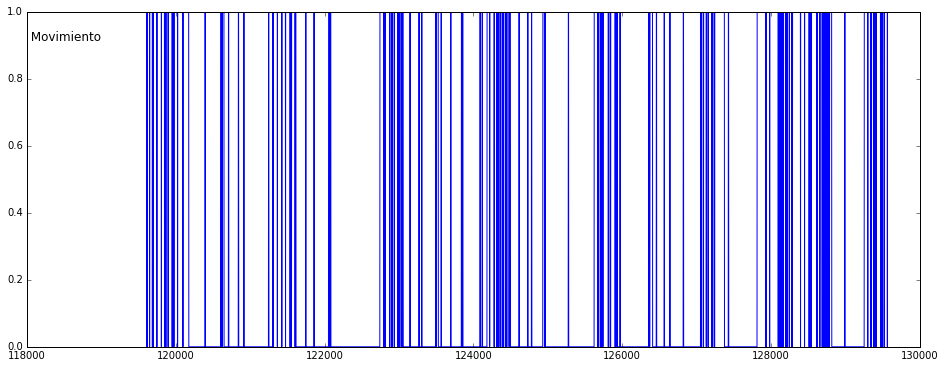

In [423]:
plt.figure(num=None, figsize=(16, 6), facecolor='w', edgecolor='k')
plt.title(' Movimiento', y=0.9, loc='left')
plt.plot(df_events['MOVEMENT'].tail(10000))
plt.show()

### Función de correlación
Esta función tiene dos entradas:
1. El dataframe panda a analizar
2. El tamáño de gráfico que se quiere imprimir

In [424]:
def plot_corr(df, size=6):
    corr = df.corr()    # data frame correlation function
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)   # color code the rectangles by correlation value
    plt.xticks(range(len(corr.columns)), corr.columns)  # draw x tick marks
    plt.yticks(range(len(corr.columns)), corr.columns)  # draw y tick marks

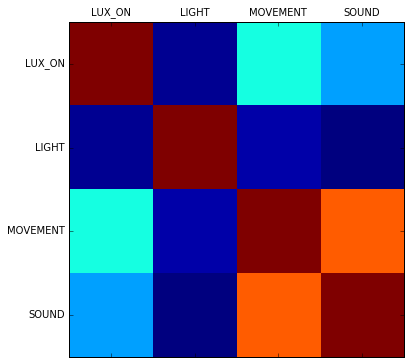

In [425]:
plot_corr(df_events)

In [426]:
df_events.corr().style.bar(subset=['LUX_ON'], color='#d65f5f', axis=0)

## Conversión de serie a aprendizaje supervisado

Convierto los datos de un formato secuencial a uno de aprendizaje supervisado. Para eso tengo que hacer dos cosas:
- Normalizar los valores de las variables al rango de activación de la función tanh() (-1 a 1)
- Crear las variables LUX_ON_1m, LIGHT_1m, MOVEMENT_1m y SOUND_1m


In [427]:
from sklearn import preprocessing

columns = df_events.columns
x = df_events.values #returns a numpy array
#scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
x_scaled = scaler.fit_transform(x)
df_events = pd.DataFrame(x_scaled)
df_events.columns = columns
df_events.head()

,LUX_ON,LIGHT,MOVEMENT,SOUND
0,0.0,0.793741,0.0,0.161150
1,0.0,0.773826,0.0,0.114923
2,0.0,0.798009,0.0,0.199479
3,0.0,0.887624,0.0,0.113330
4,0.0,0.887624,0.0,0.126683


In [428]:
df_events['LUX_ON_1m'] = df_events.LUX_ON.shift(1)
df_events['LIGHT_1m'] = df_events.LIGHT.shift(1)
df_events['MOVEMENT_1m'] = df_events.MOVEMENT.shift(1)
df_events['SOUND_1m'] = df_events.SOUND.shift(1)
df_events.head()

,LUX_ON,LIGHT,MOVEMENT,SOUND,LUX_ON_1m,LIGHT_1m,MOVEMENT_1m,SOUND_1m
0,0.0,0.793741,0.0,0.161150,NaN,NaN,NaN,NaN
1,0.0,0.773826,0.0,0.114923,0.0,0.793741,0.0,0.161150
2,0.0,0.798009,0.0,0.199479,0.0,0.773826,0.0,0.114923
3,0.0,0.887624,0.0,0.113330,0.0,0.798009,0.0,0.199479
4,0.0,0.887624,0.0,0.126683,0.0,0.887624,0.0,0.113330


In [429]:
df_events.min()

LUX_ON         0.0
LIGHT          0.0
MOVEMENT       0.0
SOUND          0.0
LUX_ON_1m      0.0
LIGHT_1m       0.0
MOVEMENT_1m    0.0
SOUND_1m       0.0
dtype: float64

### Chequeo de valores null

In [430]:
# columnas con null
df_events.isnull().any()

LUX_ON         False
LIGHT          False
MOVEMENT       False
SOUND          False
LUX_ON_1m       True
LIGHT_1m        True
MOVEMENT_1m     True
SOUND_1m        True
dtype: bool

Algunas filas, incluyendo la primera, tendran valores NaN. Voy a eliminar los registros en donde haya algún NaN.

In [431]:
df_events.shape

(129600, 8)

In [432]:
# Se elininan los eventos de estado sin sensado
df_events.dropna(inplace=True)
df_events.isnull().any()

LUX_ON         False
LIGHT          False
MOVEMENT       False
SOUND          False
LUX_ON_1m      False
LIGHT_1m       False
MOVEMENT_1m    False
SOUND_1m       False
dtype: bool

In [433]:
df_events.shape

(129599, 8)

## Entrenamiento y verificación de RNA

### Variable objetivo: estado de la lámpara (LUX_ON)
La variable a predecir es LUX_ON, la cual está en 1 si la luz está prendida (sea estado override o no del módulo). La distribución del estado en porcentaje es la siguiente:

In [434]:
df_events.LUX_ON.value_counts(normalize=True)

0.0    0.833008
1.0    0.166992
Name: LUX_ON, dtype: float64

#### Separando los datos para training y prueba
Para poder hacer etapas de entrenamiento y prueba, voy a separar los datos. 70% para entrenamiento, 30% para prueba. Para esto voy a usar del módulo scikit-learn la función train_test_split.


In [435]:
df_events.head(1)

,LUX_ON,LIGHT,MOVEMENT,SOUND,LUX_ON_1m,LIGHT_1m,MOVEMENT_1m,SOUND_1m
1,0.0,0.773826,0.0,0.114923,0.0,0.793741,0.0,0.16115


Los conjuntos de datos van a llamarse:
* X_train: Datos de entrenamiento. Las 7 columnas con los valores LIGHT, MOVEMENT, SOUND, sus valores en el minuto anterior, y LUX_ON_1m, la variable que quiero predecir, pero en el minuto anterior. Estará compuesto por el 70% de los registros.
* y_train: Resultado de entrenamiento. Columna *LUX_ON* para el 70% de los registros
* X_test: Datos para hacer la validación. Tienen el mismo formato que X_train, pero corresponden al 30% del conjunto de datos
* y_test: Resultados para validar la performance del algoritmo aplicado a X_test

In [436]:
from sklearn.model_selection import train_test_split

luxState_feature_names = ['LIGHT', 'SOUND', 'MOVEMENT', 'LIGHT_1m', 'SOUND_1m', 'MOVEMENT_1m', 'LUX_ON_1m']
luxState_goal_names = ['LUX_ON']

luxState_features = df_events[luxState_feature_names].values     # Columnas del predictor (7 X m)
luxState_goal = df_events[luxState_goal_names].values            # Clase predecida (1=verdadero, 0=falso) column (1 X m)
split_test_size = 0.30                                           # 0.30 es 30%, el tamaño para pruebas

luxState_features_train, luxState_features_test, luxState_goal_train, luxState_goal_test = train_test_split(luxState_features, luxState_goal, test_size=split_test_size)

Verifico que el tamaño relativo de los sets de entrenamiento y prueba sea lo más cercano a 70-30 posible:

In [437]:
print("{0:.2f}% en el set de entrenamiento".format( (float(len(luxState_features_train))/len(df_events.index)) * 100 ) )
print("{0:.2f}% en el set de prueba".format((float(len(luxState_features_test))/len(df_events.index)) * 100))

70.00% en el set de entrenamiento
30.00% en el set de prueba


Verifico que la proporción de casos verdaderos y falsos se mantenga en los conjuntos de entrenamiento y test:

In [438]:
print("Lux Activo en el total           : {0} ({1:0.2f}%)".format(len(df_events.loc[df_events['LUX_ON'] == 1]), (len(df_events.loc[df_events['LUX_ON'] == 1])/float(len(df_events.index))) * 100.0))
print("Lux Inactivo en el total         : {0} ({1:0.2f}%)".format(len(df_events.loc[df_events['LUX_ON'] == 0]), (len(df_events.loc[df_events['LUX_ON'] == 0])/float(len(df_events.index))) * 100.0))
print("")
train_state_on = len(luxState_goal_train[ luxState_goal_train == 1])
train_state_off = len(luxState_goal_train[ luxState_goal_train == 0])
print("Lux Activo en entrenamiento      : {0} ({1:0.2f}%)".format(train_state_on, train_state_on/float(len(luxState_goal_train)) * 100.0))
print("Lux Inctivo en entrenamiento     : {0} ({1:0.2f}%)".format(train_state_off, train_state_off/float(len(luxState_goal_train)) * 100.0))
print("")
test_state_on = len(luxState_goal_test[ luxState_goal_test == 1])
test_state_off = len(luxState_goal_test[ luxState_goal_test == 0])
print("Lux Activo en test               : {0} ({1:0.2f}%)".format(test_state_on, test_state_on/float(len(luxState_goal_test)) * 100.0))
print("Lux Inctivo en test              : {0} ({1:0.2f}%)".format(test_state_off,test_state_off/float(len(luxState_goal_test)) * 100.0))

Lux Activo en el total           : 21642 (16.70%)
Lux Inactivo en el total         : 107957 (83.30%)

Lux Activo en entrenamiento      : 15300 (16.87%)
Lux Inctivo en entrenamiento     : 75419 (83.13%)

Lux Activo en test               : 6342 (16.31%)
Lux Inctivo en test              : 32538 (83.69%)


In [439]:
from sklearn.neural_network import MLPClassifier
clf_model_state = MLPClassifier(activation='tanh')
%time clf_model_state.fit(luxState_features_train, luxState_goal_train.ravel())

CPU times: user 35.7 s, sys: 115 ms, total: 35.8 s
Wall time: 37 s


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

#### Performance usando los datos de entrenamiento
Para esto voy a importar la función metrics.

In [440]:
from sklearn import metrics

clf_predict_state_train = clf_model_state.predict(luxState_features_train)

print("Precisión en entrenamiento: {0:.4f}".format(metrics.accuracy_score(luxState_goal_train, clf_predict_state_train)))

Precisión en entrenamiento: 0.9755


#### Performance usando los datos de prueba

In [441]:
clf_predict_state_test = clf_model_state.predict(luxState_features_test)

print("Precisión en test: {0:.4f}".format(metrics.accuracy_score(luxState_goal_test, clf_predict_state_test)))

Precisión en test: 0.9757


#### Métricas
Los resultados de las etapas de entrenamiento y prueba son muy buenos. Demasiado buenos. Hay que analizar si no hay algún otro problema que pueda causar que cuando ponga más datos (cuando analice en tiempo real la actividad del usuario), el modelo falle miserablemente.

Para este análisis, voy a ver como se comparan los resultados, con el objetivo de entender si el modelo sirve o hay que hacer ajustes. Voy a usar dos herramientas:

##### Matriz de confusión
https://es.wikipedia.org/wiki/Matriz_de_confusi%C3%B3n

Cada columna de la matriz representa el número de predicciones de cada clase, mientras que cada fila representa a las instancias en la clase real. Uno de los beneficios de las matrices de confusión es que facilitan ver si el sistema está confundiendo dos clases. 

En nuestro caso, la matriz representa lo siguiente:


| EV (Predicho Encendido y es verdad ) | EF (Predicho Encendido pero es falso) |
|------------------------------------------------|
| **AF (Predicho Apagado pero es Falso** | **AV (Predicho Apagado y es verdad)** |

Esto quiere decir que queremos los valores más altos posibles en la diagonal, y lo más cerca posible a cero en cualquier otro lado.

In [442]:
print("Matriz de confusión:")
print("{0}".format(metrics.confusion_matrix(luxState_goal_test, clf_predict_state_test, labels=[1, 0])))

Matriz de confusión:
[[ 5614   728]
 [  216 32322]]


Estos resultados son muy buenos, el porcentaje de acertados es altísimo. El modelo es casi perfecto. Para confirmar, hay que usar la otra herramienta.


#### Reporte de clasificación.
Lo primero que vamos a verificar es que tan bien se hace una predición acertada cuando se requiere que el dispositivo esté encendido. Este dato, llamado "recall" en el reporte, esta dado por:

Recall = EV / (EV + AF)

Lo segundo que queremos ver es la presición, que está dada por:

Precision = EV / (EV + EF)


In [443]:
print("Reporte de clasificación:")
print(metrics.classification_report(luxState_goal_test, clf_predict_state_test, labels=[1,0]))

Reporte de clasificación:
             precision    recall  f1-score   support

          1       0.96      0.89      0.92      6342
          0       0.98      0.99      0.99     32538

avg / total       0.98      0.98      0.98     38880



## Validación del modelo

### Predicción de ESTADO (LUX_ON)
Features:

| LIGHT | MOVEMENT | SOUND | LUX_ON_1m | LIGHT_1m | MOVEMENT_1m | SOUND_1m |
|--------------------------------------------------------------------------|
| 0-800 | 0/1 | 35-110 | 0/1 | 0-800 | 0/1 | 35-110 |

In [444]:
X_new_test = pd.DataFrame([[ 400, 0, 35, 400, 0, 0, 35 ]],columns=luxState_feature_names)

In [445]:
clf_predict_new_test = clf_model_state.predict(X_new_test)

print ("Resultado: ", clf_predict_new_test)

Resultado:  [ 0.]
